### Reading EEG

In [4]:
import numpy as np
from neo.io import RawBinarySignalIO


def read_eeg_file(file_name: str, num_channels: int = 11,
                   sampling_rate: int = 1250, dtype: str = 'int16') -> np.array:
    """
    Read our EEG file using Neo library into Numpy array 
    (dtype here is NOT the dtype of resulting array), leave it as default
    """
    reader = RawBinarySignalIO(filename=file_name, sampling_rate=sampling_rate,
                            nb_channel=num_channels, dtype=dtype)
    all_data = reader.read()
    assert len(all_data) == 1
    block = all_data[0]

    # Extract the first segment and signal
    assert len(block.segments) == 1
    segment = block.segments[0]  # Get Segment (continuous recording)

    """Get specific type of recording EEG
    |  several continuous, analog signals that
    |  have the same duration, sampling rate and start time.
    |  Basically, it is a 2D array: dim 0 is time, dim 1 is
    |  channel index
    """
    assert len(segment.analogsignals) == 1, f"maybe path is not correct, found signals: {len(segment.analogsignals)}"
    analog_signal = segment.analogsignals[0]
    signal = analog_signal.magnitude
    
    return signal

### Reading records

In [5]:
import re
from collections import defaultdict


def map_seconds_to_indices(time_intervals: tuple, sampling_rate: int = 1250) -> list:
    """
    Convert time intervals in seconds to indices based on a sampling rate.

    :param time_intervals: List of tuples representing time intervals in seconds.
    :param sampling_rate: Sampling rate in Hz.
    :return: List of tuples representing index intervals.
    """
    return [
        (int(start * sampling_rate), int(end * sampling_rate))
        for start, end in time_intervals
    ]


def parse_record(record: str) -> dict:
    """Read record as string and convert it to dict"""
    result = {
        'Fname': None,
        'SP': None,
        'SO': None,
        'SR': None,
        'SLM': None,
        'HF': None,
        'DG': None,
        'LS': None,
        'PFC': None,
        'EEG': None,
        'EMG': None,
        'QualitySignal': None,
    }

    # Extract fields using individual patterns
    patterns = {
        'Fname': re.compile(r"\.Fname='(.+?)';"),
        'SP': re.compile(r"\.SP=\[(.*?)\];"),
        'SO': re.compile(r"\.SO=\[(.*?)\];"),
        'SR': re.compile(r"\.SR=\[(.*?)\];"),
        'SLM': re.compile(r"\.SLM=\[(.*?)\];"),
        'HF': re.compile(r"\.HF=\[(.*?)\];"),
        'DG': re.compile(r"\.DG=\[(.*?)\];"),
        'LS': re.compile(r"\.LS=\[(.*?)\];"),
        'PFC': re.compile(r"\.PFC=\[(.*?)\];"),
        'EEG': re.compile(r"\.EEG=\[(.*?)\];"),
        'EMG': re.compile(r"\.EMG=\[(.*?)\];"),
        'QualitySignal': re.compile(r"\.QualitySignal=\[(.*?)\];"),
    }

    for field, pattern in patterns.items():
        match = pattern.search(record)
        if match:
            values = match.group(1).strip()
            if field == 'Fname':
                result[field] = values  # Keep as a string
            elif field == 'QualitySignal' and values:
                # Handle semicolon-delimited lists for QualitySignal
                intervals = [
                    tuple([float(x) for x in sublist.split()])
                    for sublist in values.split(';')
                ]
                result[field] = map_seconds_to_indices(intervals)
            elif values:  # Only process non-empty lists
                # Convert string representation of list to Python list
                result[field] = [float(v) if '.' in v else int(v) for v in values.split()]

    return result


def parse_recording_metadata(file_path, return_all_classes=True):
    """
    Read recording file and return them and
    (oprionally) all signal types that could be seen there
    """
    with open(file_path, 'r') as file:
        data = file.read()

    # Split the data into records based on blank lines
    records = [rec.strip() for rec in data.split("\n\n") if rec.strip()]

    # Parse each record
    parsed_records = [parse_record(record) for record in records]
    num_records = defaultdict(int)

    if return_all_classes:
        for record in parsed_records:
            for key, value in record.items():
                if value is not None and key != "Fname" and key != 'QualitySignal':
                    num_records[key] += len(value)

        classes = num_records.keys()
        return parsed_records, list(classes)
    else:
        return parsed_records

### Convert eeg format to numpy bin files and store on WSL (don't run if it was done already)

In [6]:
import os
from tqdm import tqdm
from scipy.signal import decimate

CONVERTED_FOLDER_PATH = "/home/Aziz"
ORIGINAL_FOLDER_PATH = '/mnt/c/Aziz/EEG/'
DOWNSAMPLING_FACTOR = 10

In [4]:
metadata_path = '/mnt/c/Aziz/EEG/SelectionForML.txt'
recordings, CLASSES = parse_recording_metadata(metadata_path, return_all_classes=True)

# Convert to numpy and save them at Linux WSL folder
signal_paths = []
for record in tqdm(recordings):
    signal_path = ORIGINAL_FOLDER_PATH + record['Fname']
    signal = read_eeg_file(signal_path)
    for label in CLASSES:
        if record[label]:
            for channel_num in record[label]:
                file_name = os.path.basename(signal_path).replace(".eeg", "") + f"ch{channel_num}_{label}"
                output_path = os.path.join(CONVERTED_FOLDER_PATH, f"{file_name}.npy")

                signal_channel = signal[:, channel_num]

                # Downsample the signal and ensure it's contiguous
                signal_channel = decimate(signal_channel, DOWNSAMPLING_FACTOR, axis=0)  # Apply low-pass filtering
                signal_channel = np.ascontiguousarray(signal_channel)  # Ensure no negative strides

                # Save as .npy file in the output directory
                np.save(output_path, signal_channel)

100%|██████████| 137/137 [13:59<00:00,  6.13s/it]


### Creating Dataset and Data Loader

In [7]:
import numpy as np
import torch
import os
import random
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

CUT_LENGTH = 1024  # num of samples to cut out of whole sample to train on

In [8]:
class EEGDataset(Dataset):
    def __init__(self, directory_path: list, recordings: list,
                 label_encoder: LabelEncoder, max_length: int = CUT_LENGTH,
                 balance_data: bool = True):
        """
        Args:
            max_length: indicates length of randomly samples part of signal
            that we will take, since size of the whole signal is too long
        """
        self.directory_path = directory_path
        self.recordings_info = recordings
        self.label_encoder = label_encoder
        self.max_length = max_length

        # List to store the file paths and labels
        paths_and_labels = []
        for root, _, files in os.walk(directory_path):
            for file in files:
                if file.endswith(".npy"):
                    label = file.split("_")[-1].replace(".npy", "")
                    file_path = os.path.join(root, file)
                    paths_and_labels.append((file_path, label))

        if balance_data:
            paths_and_labels = self._balance_dataset(paths_and_labels)

        self.paths_and_labels = paths_and_labels

    def _balance_dataset(self, paths_and_labels, target_samples=50, tolerance=10):
        """
        Balance the dataset by ensuring each class has between
        (target_samples - tolerance) and (target_samples + tolerance) samples.
        """
        lower_bound = target_samples - tolerance
        upper_bound = target_samples + tolerance
        labels = [label for _, label in paths_and_labels]
        self.label_counts = Counter(labels)

        balanced_data = []
        for label, count in self.label_counts.items():
            samples = [item for item in paths_and_labels if item[1] == label]

            if count < lower_bound:  # Oversample by duplicating existing samples
                oversampled = random.choices(samples, k=target_samples)
                balanced_data.extend(oversampled)
            elif count > upper_bound:  # Undersample by removing samples
                undersampled = random.sample(samples, k=target_samples)
                balanced_data.extend(undersampled)
            else:  # Keep the samples as is if within bounds
                balanced_data.extend(samples)

        return balanced_data

    @staticmethod
    def random_sample(signal, sample_size):
        """take random cut from sample"""
        if len(signal) <= sample_size:
            return signal
        start_idx = random.randint(0, len(signal) - sample_size)
        return signal[start_idx:start_idx + sample_size]

    def __len__(self):
        return len(self.paths_and_labels)
    
    def __getitem__(self, idx):
        file_path = self.paths_and_labels[idx][0]
        label = self.paths_and_labels[idx][1]

        recording_arr = np.load(file_path)  # Shape: (num_samples, 1)
        
        signal_data = self.random_sample(signal=recording_arr,
                                        sample_size=self.max_length
                                        )  # Randomly cut signal to needed size
        signal_data = torch.tensor(signal_data).unsqueeze(0)

        label = self.label_encoder.transform([label])

        return torch.tensor(signal_data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [9]:
metadata_path = '/mnt/c/Aziz/EEG/SelectionForML.txt'
recordings, CLASSES = parse_recording_metadata(metadata_path, return_all_classes=True)

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(CLASSES)

dataset = EEGDataset(CONVERTED_FOLDER_PATH, recordings, label_encoder)

In [10]:
def collate_fn(batch):
    """
    Custom collate function to stack signals directly, assuming each signal has only one channel.
    """
    all_signals = []
    all_labels = []

    for signals, labels in batch:
        # Append the single-channel signals and their labels directly
        all_signals.append(signals)  # Shape: (num_samples,)
        all_labels.append(labels)   # Corresponding label

    # Pad signals to the maximum length in the batch
    padded_signals = pad_sequence(
        [torch.tensor(signal) for signal in all_signals],
        batch_first=True
    )  # Shape: (batch_size, max_length)

    return padded_signals, torch.tensor(all_labels, dtype=torch.long)


data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, drop_last=True)

### Train

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

from tsai.models.PatchTST import PatchTST
from tsai.all import TSClassification, TSStandardize, get_ts_dls, Learner, build_ts_model, accuracy, ShowGraph
from fastai.callback.tracker import SaveModelCallback

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

### Train with tsai

In [9]:
"""DATA PREPARATION FOR TSAI"""
# Extract data from DataLoader
# X, y = [], []
# for batch_samples, batch_labels in tqdm(data_loader):
#     X.append(batch_samples)
#     y.append(batch_labels)

# X = torch.cat(X)  # Combine batches: shape (total_samples, num_channels, sequence_length)
# y = torch.cat(y)  # Combine labels: shape (total_samples,)

# X = X.unsqueeze(1)  # New shape: (num_samples, 1, max_length)

100%|██████████| 195/195 [00:50<00:00,  3.89it/s]


In [19]:
# from sklearn.model_selection import train_test_split
# # Get the indices for splits
# n_samples = len(X)  # Total number of samples
# indices = np.arange(n_samples)

# # Perform the same split but keep indices
# train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
# splits = (list(train_indices), list(test_indices))

# tfms  = [None, TSClassification()] # TSClassification == Categorize
# batch_tfms = TSStandardize()
# dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[4, 4])
# dls.dataset

In [ ]:
# model = build_ts_model(PatchTST, dls=dls)
# learn = Learner(dls, model, metrics=accuracy)

In [22]:
# learn = Learner(dls, model, metrics=accuracy, cbs=ShowGraph())
# learn.load('best_model_new')

In [ ]:
# learn.fit_one_cycle(100, lr_max=1e-7, cbs=SaveModelCallback(fname='best_model_new2'))

### Train with Pytorch

In [12]:
class PatchTSTClassifier(nn.Module):
    def __init__(self, c_in, c_out, seq_len, n_layers=3, d_model=128, n_heads=4, conv_channels=64, num_conv_layers=4):
        """
        Args:
            c_in: Number of input channels.
            c_out: Number of output classes.
            seq_len: Length of input sequences.
            n_layers: Number of transformer layers in PatchTST.
            d_model: Embedding dimension for PatchTST.
            n_heads: Number of attention heads in PatchTST.
            conv_channels: Number of channels for convolutional layers in the classification head.
            num_conv_layers: Number of convolutional layers in the classification head.
        """
        super().__init__()
        # PatchTST backbone
        self.backbone = PatchTST(c_in=c_in, c_out=c_out, seq_len=seq_len, n_layers=n_layers, n_heads=n_heads, d_model=d_model)
        
        # Classification head with convolutional layers
        layers = []
        in_channels = c_in  # Output channels of PatchTST backbone (same as input)
        for i in range(num_conv_layers):
            layers.append(nn.Conv1d(in_channels, conv_channels, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm1d(conv_channels))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))  # Optional dropout for regularization
            in_channels = conv_channels
        self.conv_head = nn.Sequential(*layers)
        
        # Global Average Pooling and Fully Connected layer
        self.gap = nn.AdaptiveAvgPool1d(1)  # Reduce sequence length to 1
        self.fc = nn.Linear(conv_channels, c_out)  # Final classification layer

    def forward(self, x):
        """Forward pass."""
        x = self.backbone(x)  # Output shape: [batch_size, d_model, seq_len]
        x = self.conv_head(x)  # Shape: [batch_size, conv_channels, reduced_seq_len]
        x = self.gap(x).squeeze(-1)  # Shape: [batch_size, conv_channels]
        x = self.fc(x)  # Shape: [batch_size, c_out]
        return x


In [13]:
model = PatchTSTClassifier(
    c_in=1,             # Input channels (e.g., 1 for univariate signals)
    c_out=len(CLASSES), # Number of output classes
    seq_len=CUT_LENGTH,       # Input sequence length
    n_layers=12,         # Transformer layers in PatchTST
    d_model=512,        # Embedding dimension of PatchTST
    n_heads=16,         # Attention heads
    conv_channels=256,  # Channels in classification head
    num_conv_layers=6   # Number of convolutional layers
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [14]:
class SaveBestModelCallback:
    def __init__(self, save_path="best_model.pth", monitor="loss"):
        """
        Args:
            save_path: Path to save the best model.
            monitor: Metric to monitor ('loss' or 'accuracy').
        """
        self.save_path = save_path
        self.monitor = monitor
        self.best_value = float('inf') if monitor == "loss" else 0

    def check_and_save(self, model, current_value):
        """
        Save the model if the monitored metric improves.
        Args:
            model: The PyTorch model to save.
            current_value: Current value of the monitored metric.
        """
        is_better = (
            current_value < self.best_value if self.monitor == "loss"
            else current_value > self.best_value
        )
        if is_better:
            self.best_value = current_value
            torch.save(model.state_dict(), self.save_path)
            print(f"Best model saved with {self.monitor}: {current_value:.4f}")

# Initialize the callback
save_best_model = SaveBestModelCallback(save_path="/home/user/Aziz/best_patchTCT.pth", monitor="loss")  # or monitor="accuracy"

In [14]:
model.load_state_dict(torch.load("/home/user/Aziz/best_patchTCT.pth"))

<All keys matched successfully>

In [ ]:
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.squeeze().to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100. * correct / total

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    save_best_model.check_and_save(model, epoch_loss if save_best_model.monitor == "loss" else epoch_acc)


### Validate

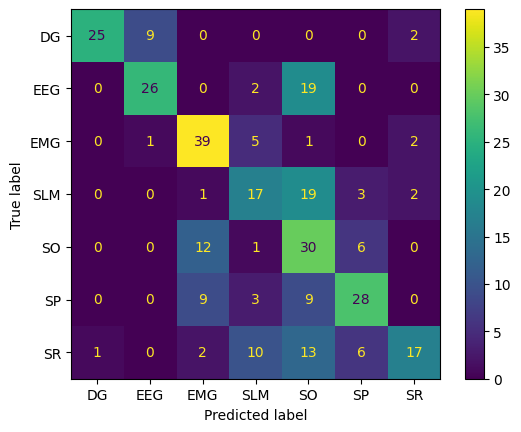

In [48]:

all_preds = []
all_labels = []

# Example during validation
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    for inputs, labels in data_loader:  # Use your validation DataLoader
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)  # Get predicted class indices
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis")

### Validation via aggregating classifications (since we cannot classify whole 30 minutes sample, we need to classify small parts of it)

In [34]:
def classify_full_signal(model, signal, seq_len=CUT_LENGTH, threshold=0., device='cuda'):
    """
    Classify a full signal by dividing it into non-overlapping chunks, 
    running the model on each chunk, and aggregating predictions based on a threshold.

    Args:
        model (nn.Module): Trained model for classification.
        signal (np.array): Input signal of shape (num_samples,).
        seq_len (int): Length of the sliding window (chunk size).
        threshold (float): Minimum probability for a chunk to contribute to the final prediction.
        device (str): Device to run the model ('cpu' or 'cuda').

    Returns:
        int: Predicted class for the full signal.
    """
    model.eval()  # Set model to evaluation mode
    signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)  # Shape: (1, num_samples)
    chunks = []

    # Divide the signal into non-overlapping chunks
    for start in range(0, len(signal[0]), seq_len):
        end = start + seq_len
        if end > len(signal[0]):  # Skip incomplete chunks
            break
        chunk = signal[:, start:end].unsqueeze(1)  # Shape: (1, 1, seq_len)
        chunks.append(chunk)

    # Process each chunk with the model
    all_predictions = []
    for chunk in chunks:
        chunk = chunk.to(device)
        with torch.no_grad():
            output = model(chunk)  # Output shape: (batch_size=1, num_classes)
            probs = torch.softmax(output, dim=1)  # Get probabilities
            max_prob = torch.max(probs).item()  # Maximum probability for the chunk
            if max_prob >= threshold:  # Include only if above threshold
                all_predictions.append(probs.cpu().numpy())  # Collect predictions

    # Check if any predictions passed the threshold
    if not all_predictions:
        return -1  # Return an invalid class if no chunk passes the threshold

    # Aggregate predictions (mean probabilities across selected chunks)
    mean_predictions = np.mean(np.vstack(all_predictions), axis=0)  # Shape: (num_classes,)
    predicted_class = np.argmax(mean_predictions)  # Get the class with the highest mean probability

    return predicted_class

In [40]:
VALIDATION_NUM_SAMPLES = 10

y_true = []
y_predicted = []
for label in CLASSES:
    selected_paths = [p for p, l in dataset.paths_and_labels if l == label]
    selected_paths = random.sample(selected_paths, min(VALIDATION_NUM_SAMPLES, len(selected_paths)))
    for file_path in tqdm(selected_paths):
        signal = np.load(file_path)
        encoded_label = label_encoder.transform([label])[0]
        predicted_label = classify_full_signal(model, signal, device='cuda')
        y_true.append(label)
        y_predicted.append(predicted_label)

100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


In [41]:
# If using threshold for classification, then remove '-1' classifications,
#  that were not even once classified above threshold (in classify_full_signal function)
true_y = []
pred_y = []
for t, p in zip(y_true, y_predicted):
    if p != -1:
        true_y.append(t)
        pred_y.append(p)

pred_y = label_encoder.inverse_transform(pred_y)

cm = confusion_matrix(y_true=true_y, y_pred=pred_y)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="viridis")

accuracy = accuracy_score(true_y, pred_y)
print(accuracy)

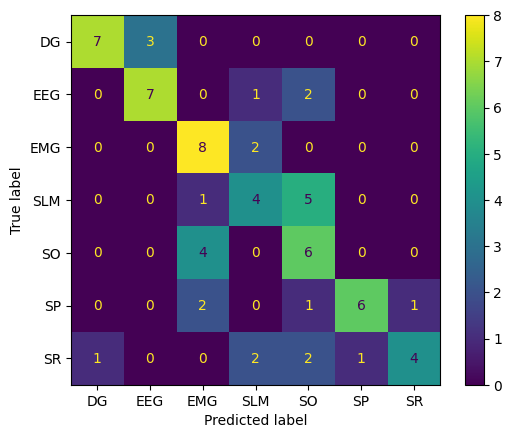